# Thí dụ mô phỏng về nghịch lý Simpson

## Bs. Lê Ngọc Khả Nhi


# Nhập đề

Trong bài này, Nhi dùng một thí dụ mô phỏng đơn giản về hiện tượng "Nghịch lý Simpson" khi khảo sát hiệu quả của can thiệp, qua đó giải thích cho các bạn về sự khác biệt giữa quan sát ngẫu nhiên trong quần thể và can thiệp mang tính cưỡng bức trong một thử nghiệm lâm sàng ngẫu nhiên đối chứng (RCT hay A/B test); từ đó thấy được hạn chế của thống kê quy ước trong cả 2 trường hợp, và nhận ra tầm quan trọng của cách tiếp cận Suy luận nhân quả.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("Set1")

Câu chuyện này giả định xảy ra tại một bệnh viện, có một em bác sĩ nội trú chuyên khoa Ngoại làm luận văn tốt nghiệp Nội trú với đề tài : khảo sát hiệu quả của phương pháp phẫu thuật nội soi mới tên là T; với kết cục là tần suất xảy ra một biến chứng Y. Em thu thập dữ liệu một cách hồi cứu từ hồ sơ bệnh án của khoảng 500 bệnh nhân từng được phẫu thuật bằng phương pháp T, đối chứng với 500 bệnh nhân khác không dùng phương pháp T.

# Trường hợp 1: Dữ liệu quan sát ngẫu nhiên

Nhi tạo một hàm mô phỏng dữ liệu 1000 bệnh nhân này (để đảm bảo bất ngờ đến phút cuối, Nhi chưa giải thích về cơ chế bên trong của hàm này). Chỉ biết rằng em bác sĩ có trong tay một dataframe gồm 2 biến nhị phân T (0 = Không dùng phương pháp mới, 1 = Có dùng phương pháp mới) và Y (0 = không xảy ra biến chứng, 1 = Có xảy ra biến chứng).

In [2]:
def simulate_bin(sample_size = 1000, forced_T = None, obs_conf = False):
    """
    Mô phỏng dữ liệu Simpson paradox với Can thiệp nhị phân:
    Hệ thống sinh dữ liệu có cấu trúc:
    
    T = Treatment (binary)
    Y = Outcome (binary)
    C = Confounder (binary)
    
    Causal diagram:
    Nodes: (C,T,Y)
    Edges: (C -> T, C-> Y, T -> Y)
    
    Args:
    sample_size : cỡ mẫu
    forced_T : điều kiện cưỡng bức T=1 hay T=0 trong một RCT (forced_T là 1 numpy array 0/1)
    obs_conf: ẩn confouder hay không ?
    
    Return:
    
    data: 1 panda dataframe gồm 2 cột T,Y (nếu obs_conf = True) hoặc 3 cột C,T,Y (nếu obs_conf = False)
    """
    p_c = 0.5
    p_t_c = [0.8, 0.2]
    p_y_tc = [0.1, 0.3, 0.7, 0.9]
    
    c = np.random.binomial(n = 1, 
                           p = p_c, 
                           size = sample_size)
    
    if forced_T is not None:
        assert(len(forced_T) == sample_size)
        t = forced_T
    else:
        p_t = np.choose(c, p_t_c)
        t = np.random.binomial(n = 1, 
                               p = p_t, 
                               size = sample_size)
        
    p_y = np.choose(t + 2*c, p_y_tc)
    
    y = np.random.binomial(n = 1, 
                           p = p_y, 
                           size = sample_size)
    
    if obs_conf:
        return pd.DataFrame({"T":t, "Y":y, "C":c})
    
    return pd.DataFrame({"T":t, "Y":y})

In [3]:
obs_data = simulate_bin(sample_size = 1000, 
                        forced_T = None, 
                        obs_conf = False)

obs_data.head()

,T,Y
0,1,0
1,1,0
2,0,1
3,1,1
4,0,1


## Thống kê quy ước

Như thường lệ, các bạn bác sĩ rất thích dùng bảng chéo để trình bày dữ liệu, nên ta cũng sẽ làm 1 bảng chéo :

In [6]:
xtab = pd.crosstab(obs_data['T'], obs_data['Y'])

xtab

Y,0,1
T,,
0,177,292
1,308,223


Bằng một tính toán đơn giản, ta thấy rằng có vẻ như cách mổ nội soi làm giảm tỉ lệ phát sinh biến chứng đến 20.26 %

In [7]:
100 *xtab[1]/ xtab.aggregate('sum', axis =1)

T
0    62.260128
1    41.996234
dtype: float64

In [9]:
41.996234 - 62.260128

-20.263894

Một cách chính xác, tỉ lệ bệnh nhân phát sinh biến chứng đã giảm trung bình 20.26 % với 95%CI từ -14.18 đến -26.34 %

In [27]:
def estimate_effect(ds):

    base = ds[ds['T'] == 0]
    variant = ds[ds['T'] == 1]
    
    delta = variant.Y.mean() - base.Y.mean()
    
    delta_err = 1.96 * np.sqrt(
        variant.Y.var() / variant.shape[0] + 
        base.Y.var() / base.shape[0])
    
    return f"Hiệu ứng trung bình: {100*delta} % : {100*(delta - delta_err)} % đến {100*(delta + delta_err)} %"

estimate_effect(obs_data)

'Hiệu ứng trung bình: -20.263894410112478 % : -26.34204883854331 % đến -14.185739981681644 %'

Dĩ nhiên, bạn bác sĩ không thể báo cáo kết quả này, mà còn phải kiểm định thống kê nữa; và như thường lệ các bạn ấy rất thích dùng Chi squared test; ta cũng sẽ tuân thủ quy trình này với 1 Test chi squared. Thậm chí, Nhi sẽ ấn định một ngưỡng ý nghĩa thống kê rất thấp là 0.001:

In [16]:
from scipy.stats import chi2_contingency

def chi_square(xtab, thres = 0.001):
    chi2_out = chi2_contingency(xtab)
    if chi2_out[1] < thres:
        print(f'Có liên hệ ý nghĩa giữa T và Y, Chi2 = {chi2_out[0]}, p_value = {chi2_out[1]}')
    else:
        print(f'T và Y độc lập với nhau, Chi2 = {chi2_out[0]}, p_value = {chi2_out[1]}')

In [17]:
chi_square(xtab, thres = 0.001)

Có liên hệ ý nghĩa giữa T và Y, Chi2 = 40.1342777651706, p_value = 2.3709200240939966e-10


Kết quả test Chisqured nhìn thích quá phải không các bạn ? Em bác sĩ này rất mãn nguyện và ghi vào luận văn: Có liên hệ ý nghĩa thống kê giữa sự giảm biến chứng hậu phẫu và phương pháp phẫu thuật T (p < 0.001).

Thầy giáo hướng dẫn gợi ý thêm: Em làm thêm mô hình logistic để tính Odds_ratio nhé !

Chúng ta sẽ làm theo như vậy:

In [18]:
import statsmodels.formula.api as sm

model_1 = sm.logit(data = obs_data, formula = 'Y ~ T').fit()

model_1.summary()

Optimization terminated successfully.
         Current function value: 0.672071
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Thu, 02 Jan 2020   Pseudo R-squ.:                 0.02978
Time:                        14:24:38   Log-Likelihood:                -672.07
converged:                       True   LL-Null:                       -692.70
Covariance Type:            nonrobust   LLR p-value:                 1.338e-10
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5006      0.095      5.255      0.000       0.314       0.687
T             -0.8235      0.130     -6.353      0.000      -1.078      -0.569
==============================================================================
"""

In [26]:
print(f'{np.exp(-0.8235)} {np.exp(-1.078)} {np.exp(-0.569)}')

0.43889283821461283 0.3402753963403008 0.5660912469952338


Theo kết quả của mô hình logistic đơn biến, em bác sĩ có thể viết thêm: Nguy cơ xảy ra biến chứng hậu phẫu ở các bệnh nhân được mổ bằng nội soi theo phương pháp T giảm 0.44 lần (0.34 đến 0.57) so với các bệnh nhân không dùng phương pháp T, p < 0.001.

# Trường hợp 2: Can thiệp cưỡng bức trong RCT

Vậy là xong, em bác sĩ trình luận văn tốt nghiệp với kết quả mỹ mãn và ra đi. Tuy nhiên câu chuyện của chúng ta không dừng lại ở đó. Trưởng khoa Ngoại đọc luận văn của em và bị ấn tượng bởi kết quả rất đẹp, ông nghĩ đến chuyện áp dụng thường quy phương pháp T cho tất cả bệnh nhân. Tuy nhiên, một giáo sư trên Sở Y tế can ngăn và khuyên nên thử làm một thử nghiệm lâm sàng đối chứng ngẫu nhiên (RCT) tại 3 bệnh viện khác nhau để kiểm tra lại hiệu quả của phương pháp T này. 

Họ làm thật, trong 1 năm tiếp theo 3 bệnh viện thực hiện nghiên cứu này, với cùng cỡ mẫu là 1000 bệnh nhân, được phân chia ngẫu nhiên vào 2 phân nhóm (T=1 và T=0). Sau 3 năm, chúng ta có dữ liệu mới như sau:

In [29]:
def simulate_AB_test(simulate_bin, sample_size =1000):
    treat_size = int(sample_size / 2)
    control_size = sample_size - treat_size
    
    forced_T = np.concatenate([np.ones(treat_size), np.zeros(control_size)]).astype('int')
    
    rct_data = simulate_bin(sample_size = sample_size, forced_T = forced_T)
    
    return rct_data

rct_data = simulate_AB_test(simulate_bin, sample_size =1000)

rct_data.head()

,T,Y
0,1,0
1,1,1
2,1,0
3,1,1
4,1,1


Các bác sĩ lặp lại quy trình phân tích thống kê trong luận văn, và đây là những gì họ có:

In [31]:
xtab_rct = pd.crosstab(rct_data['T'], rct_data['Y'])

xtab_rct

Y,0,1
T,,
0,292,208
1,195,305


In [32]:
estimate_effect(rct_data)

'Hiệu ứng trung bình: 19.400000000000002 % : 13.315738114332444 % đến 25.484261885667557 %'

Ồ ! Ngạc nhiên chưa ? Kết quả hoàn toàn bị ĐẢO NGƯỢC:

Khi dùng phương pháp T, tần suất biến chứng hậu phẫu tăng đến 19.4 % (95%CI: 13.3 đến 25.48 %)

Kết quả này được chứng thực bởi cả Chi-squared test và logistic model:

In [33]:
chi_square(xtab_rct, thres = 0.001)

Có liên hệ ý nghĩa giữa T và Y, Chi2 = 36.888936921358834, p_value = 1.2505352631829396e-09


In [34]:
model_2 = sm.logit(data = rct_data, formula = 'Y ~ T').fit()

model_2.summary()

Optimization terminated successfully.
         Current function value: 0.673858
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Thu, 02 Jan 2020   Pseudo R-squ.:                 0.02735
Time:                        14:43:11   Log-Likelihood:                -673.86
converged:                       True   LL-Null:                       -692.81
Covariance Type:            nonrobust   LLR p-value:                 7.438e-10
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3392      0.091     -3.739      0.000      -0.517      -0.161
T              0.7865      0.129      6.097      0.000       0.534       1.039
==============================================================================
"""

# Giải thích

Điều gì đã xảy ra ? Tại sao kết quả lại hoàn toàn đảo ngược giữa nghiên cứu quan sát-hồi cứu và nghiên cứu thử nghiệm lâm sàng đối chứng ngẫu nhiên với cùng cỡ mẫu ? 

Các bạn vừa chứng kiến một trường hợp nghịch lý Simpson, là một cái bẫy nguy hiểm khi làm phân tích thống kê theo cách làm truyền thống. Nguyên nhân dẫn đến nghịch lý này ẩn giấu bên trong nội dung của quy trình mô phỏng dữ liệu, ta sẽ phân tích quy trình này:

Trong cả 2 thiết kế nghiên cứu (Quan sát ngẫu nhiên và Can thiệp cưỡng bức), giá trị của T,Y được sinh ra từ một hệ thống có cấu trúc như sau:

Xác suất của T=1 (can thiệp bằng phương pháp T) trên thực tế phụ thuộc vào 1 biến Z và biến Z này cũng có liên hệ với kết quả Y (Biến chứng xảy ra hay không).

Như vậy Z là 1 confounder làm nhiễu kết quả của hiệu ứng can thiệp delta = Y|(T=1) - Y|(T=0), tuy nhiên không phải lúc nào người ta cũng ý thức về sự tồn tại và bản chất của confouder Z này. Trong thí dụ ta vừa đưa ra, Z bị ẩn đi (không được ghi nhận trong dữ liệu) nhưng nó vẫn luôn đứng đằng sau chi phối T và Y.

Trong trường hợp luận văn của em bác sĩ, em ấy dùng dữ liệu quan sát ngẫu nhiên, khi đó cả Y,T và C đều được tự do và mạng lưới liên hệ nhân quả giữa chúng chính là hình ảnh dưới đây:

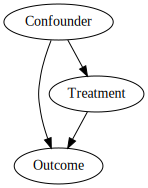

In [35]:
from causalgraphicalmodels import CausalGraphicalModel

model_obs = CausalGraphicalModel(
    nodes=["Treatment", "Outcome", "Confounder",],
    edges=[("Confounder", "Treatment"), 
           ("Confounder", "Outcome"), 
           ("Treatment", "Outcome"), ])

model_obs.draw()

Tuy nhiên, khi người ta cưỡng bức một bệnh nhân bất kì dùng phương pháp phẫu thuật mới (T=1) trong nghiên cứu RCT, sơ đồ nhân quả trở thành như sau: T trở nên độc lập với Z; tuy nhiên Z vẫn ảnh hưởng lên Y. Đáng tiếc là người ta đã không ý thức về sự tồn tại của Z nên đã không quan sát gì đến nó:

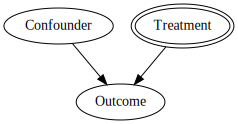

In [37]:
model_rct = model_obs.do('Treatment')

model_rct.draw()

Thí dụ: ta có thể hình dung Confounder Z là Độ nặng hay phân loại bệnh lý; Z cũng có thể là kỹ năng phẫu thuật của phẫu thuật viên hoặc Hoàn cảnh kinh tế của bệnh nhân...

Để tìm ra câu trả lời đúng cho câu hỏi: Liệu phương pháp phẫu thuật mới có hiệu quả làm giảm biến chứng hay không ? Ta phải khảo sát Z bằng cách thay đổi tùy chỉnh obs_conf = True trong hàm mô phỏng), và mô phỏng lại dữ liệu cho thí nghiệm RCT:

Ở đây giả định confounder Z là 1 biến nhị phân:

In [98]:
def simulate_AB_test_with_C(simulate_bin, sample_size =1000):
    treat_size = int(sample_size / 2)
    control_size = sample_size - treat_size
    
    forced_T = np.concatenate([np.ones(treat_size), np.zeros(control_size)]).astype('int')
    
    rct_data = simulate_bin(sample_size = sample_size, forced_T = forced_T, obs_conf = True)
    
    return rct_data

rct_with_c_data = simulate_AB_test_with_C(simulate_bin, sample_size =1000)

rct_with_c_data.head()

,T,Y,C
0,1,1,1
1,1,1,1
2,1,0,0
3,1,0,0
4,1,1,1


Sau đó ta khảo sát riêng 2 trường hợp : C=0 và C=1

In [99]:
df_c0 = rct_with_c_data[rct_with_c_data.C == 0]
df_c1 = rct_with_c_data[rct_with_c_data.C == 1]

ta sẽ thấy rằng trong cả 2 phân nhóm C=0 và C=1, hiệu ứng can thiệp đều > 0, tức là phương pháp phẫu thuật mới thực ra làm tăng nguy cơ biến chứng chứ không phải làm giảm

In [131]:
estimate_effect(df_c0)

'Hiệu ứng trung bình: 16.959977292080612 % : 10.236745766035128 % đến 23.6832088181261 %'

In [101]:
estimate_effect(df_c1)

'Hiệu ứng trung bình: 20.91473224546081 % : 13.845595415229281 % đến 27.983869075692336 %'

Kết quả này tương đương với mô hình logistic có xét C + T

In [102]:
model_3 = sm.logit(data = rct_with_c_data, formula = 'Y ~ T+C').fit()

model_3.summary()

Optimization terminated successfully.
         Current function value: 0.456361
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      997
Method:                           MLE   Df Model:                            2
Date:                Thu, 02 Jan 2020   Pseudo R-squ.:                  0.3412
Time:                        15:39:38   Log-Likelihood:                -456.36
converged:                       True   LL-Null:                       -692.70
Covariance Type:            nonrobust   LLR p-value:                2.295e-103
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2552      0.167    -13.481      0.000      -2.583      -1.927
T              1.2843      0.175      7.324      0.000       0.941       1.628
C              3.0608      0.175     17.445      0.000       2.717       3.405
==============================================================================
"""

# Backdoor adjustment với package dowhy

Cuối cùng, Nhi dùng phương pháp suy luận nhân quả, sử dụng backdoor adjustment và propensity score stratification với package dowhy:

In [125]:
rct_with_c_data['T'] = rct_with_c_data['T'].astype('bool')

In [126]:
dg = 'digraph {T->Y; C->Y; C->T;}'

from dowhy import CausalModel

model = CausalModel(rct_with_c_data,
                    treatment = ['T'],
                    outcome = ['Y'],
                   graph = dg)

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. DLL load failed: %1 n’est pas une application Win32 valide.
Trying pydot ...
INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['T'] on outcome ['Y']


In [130]:
identified_estimand = model.identify_effect()

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['C', 'U']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


In [129]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att")
print(causal_estimate_strat)
print("Hiệu ứng can thiệp = " + str(causal_estimate_strat.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: Y~T+C


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                   
──(Expectation(Y|C))
dT                  
Estimand assumption 1, Unconfoundedness: If U→T and U→Y then P(Y|T,C,U) = P(Y|T,C)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Y~T+C
## Estimate
Value: 0.19063906927278879

Hiệu ứng can thiệp = 0.19063906927278879


C:\Users\bacsi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Kết quả tương tự, tức là hiệu ứng can thiệp = 0.191 hay +19% > 0;
Kết luận cuối cùng là phương pháp mới không làm giảm biến chứng nhưng làm tăng, do đó không tốt hơn phương pháp thông thường.

# Kết luận

Một số vấn đề có thể rút ra từ thí nghiệm mô phỏng này:

1) Bản thân dữ liệu không quan trọng bằng cách thức mà dữ liệu được sinh ra (hệ thống, quy luật);

2) Nghiên cứu lâm sàng đối chứng là tốt, tuy nhiên cần chú ý về sự tồn tại của confounders, mặt khác phân bố của hiệu ứng can thiệp mang tính cưỡng bức (áp dụng 1 chính sách can thiệp trên diện rộng) không tương đương với hiệu ứng quan sát ngẫu nhiên. 

3) Đúng như lời cảnh báo trong thống kê cổ điển: Tương quan không đồng nghĩa với liên hệ nhân quả: Trong cả 2 trường hợp test Chisquare đều cho ra kết quả dương tính về liên hệ có ý nghĩa thống kê

4) Nghịch lý Simpson là một trường hợp cực đoan khi mà confounder hoàn toàn không được kiểm soát (vi phạm giả định về tính độc lập có điều kiện của can thiệp). 

5) Nếu không được dẫn đường bằng lý thuyết và sơ đồ nhân quả, thống kê quy ước rất dễ rơi vào bẫy  nghịch lý, từ đó rút ra những quyết định sai lầm.